## PDE from JAX Docs

The following corresponds to the first approach of PINNs, where they are used to solve equations with given parameters. The code used for the first section (pure JAX) is based on code from [this](https://github.com/ASEM000/Physics-informed-neural-network-in-JAX) repository.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import optax

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns

We wish to solve the following equation

$$ \frac{\partial u\left(t,x\right)}{\partial t} + u\left(t,x\right)\frac{\partial u\left(t,x\right)}{\partial x} - v \frac{\partial^2 u\left(t,x\right)}{\partial x^2} = 0, \hspace{10mm} (t,x) \in (0,1] \times (-1,1), $$
    
subject to the following initial and boundary conditions, respectively:

$$ u(t=0,x) = - \sin(\pi \, x), \hspace{10mm} x \in [-1,1], $$
$$ u(t,x=-1) = u(t,x=1) = 0, \hspace{10mm} t \in (0,1]. $$

The value we choose for $v$ is $v = 0.01/\pi$.

First, we setup the grid on which we will solve the equation.

In [2]:
# Set the number of points to be used
N_0 = 100 # initial condition points
N_b1 = 100 # boundary condition #1 points
N_b2 = 100 # boundary condition #2 points
N_f = 10000 # collocation points

# Domains of t and x
tmin, tmax = 0.0, 1.0
xmin, xmax = -1.0, 1.0

# seed key for debugging
np.random.seed(420)

# ------------------------------------------
# Initial Condition (IC): u(t=0,x) = -sin(pi*x)
# ------------------------------------------

# list of zeros
t_0 = jnp.ones([N_0,1],dtype='float32')*0.0
# random values of uniform distribution to be used for IC points - x
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
# apply the IC function on the collected points
ic_0 = -jnp.sin(jnp.pi*x_0)
# Array of shape (N_0, 3), containing elements (t=0,x,u(x))
IC_0 = jnp.concatenate([t_0,x_0,ic_0],axis=1)

# ------------------------------------------
# Boundary condition (BC) #1: u(t,x=-1) = 0
# ------------------------------------------

# random values of uniform distribution to be used for BC#1 points - t
t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b1,1))
# a list of -1 of size equal to the size of t_b1
x_b1 = jnp.ones_like(t_b1) *-1
# a list of zeros of size equal to the size of t_b1
bc_1 = jnp.zeros_like(t_b1)
# Array of shape (N_0, 3), containing elements (t,x=-1,u(x)=0)
BC_1 = jnp.concatenate([t_b1,x_b1,bc_1],axis=1)

# ------------------------------------------
# Boundary condition (BC) #2: u(t,x=1) = 0
# ------------------------------------------

# random values of uniform distribution to be used for BC#2 points - t
t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b2,1))
# a list of 1 of size equal to the size of t_b2
x_b2 = jnp.ones_like(t_b2)
# a list of zeros of size equal to the size of t_b1
bc_2 = jnp.zeros_like(t_b2)
# Array of shape (N_0, 3), containing elements (t,x=1,u(x)=0)
BC_2 = jnp.concatenate([t_b2,x_b2,bc_2],axis=1)

# collect all the condition-triplets (t,x,u)
conds = [IC_0,BC_1,BC_2]

# collocation points
# t ∈ [0,1]
t_c = np.random.uniform(low=tmin,high=tmax,size=(N_f,1))
# x ∈ [-1,1]
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_f,1))
colloc = jnp.concatenate([t_c,x_c],axis=1) 

The following cell visualizes our chosen points.

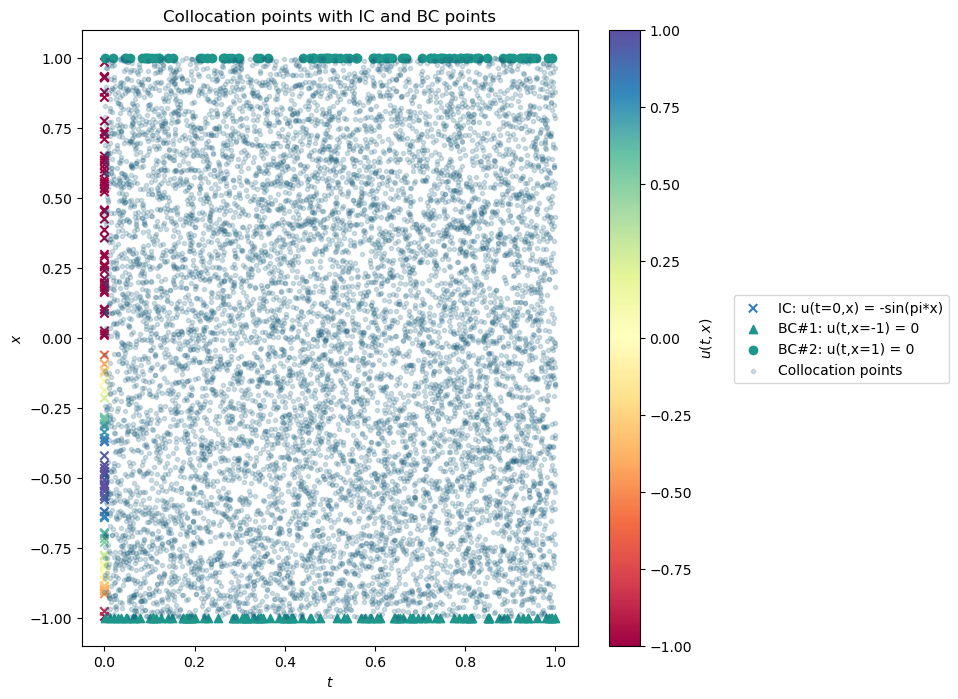

In [3]:
fig = plt.figure(figsize=(8,8))

cmap = 'Spectral'

plt.scatter(t_0, x_0, c=ic_0, marker='x', vmin=0, vmax=1,label='IC: u(t=0,x) = -sin(pi*x)', cmap=cmap)
plt.scatter(t_b1, x_b1, color='#1f968b', marker='^', vmin=-1, vmax=1,label='BC#1: u(t,x=-1) = 0')
plt.scatter(t_b2, x_b2, color='#1f968b', marker='o', vmin=-1, vmax=1,label='BC#2: u(t,x=1) = 0')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

plt.scatter(t_c, x_c, color='#1a5d7b', marker='.', alpha=0.2,label='Collocation points')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')

plt.title('Collocation points with IC and BC points')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label(r'$u(t,x)$', rotation=90)

plt.legend(bbox_to_anchor=(1.3, 0.58))
plt.show()

Then, we setup the PINN function $f(t,x)$. The loss for this function is

$$ \text{MSE}_f = \frac{1}{N_f}\sum_{i=1}^{N_f}{\left|f\left(t_f^i, x_f^i\right) \right|^2} \hspace{10mm} (1) $$

and it penalizes the Burgers' equation not being satisfied on the collocation points. This, essentially, acts as a regularization.

Note that `jax.grad(fun, argnums)` returns a function with the same arguments as `fun`, that evaluates the gradient of `fun` with respect to the variable in position `argnums`. Be careful with this, because the default value of `argnums` is 0.

**Some Notes:**

`lambda t,x : jnp.sum(ufunc(t,x))` defines a function of $(t,x)$ which is the sum of the output of `ufunc(t,x)`.

`jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)` is a function of $(t,x)$, just like its argument. It corresponds to the derivative of its argument with respect to $x$.

`jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)(t,x)` calls the function on the input $(t,x)$, therefore the statement `lambda t,x : jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)(t,x)` defines a function, `u_x(t,x)`.

This function statement is equivalent to `u_x = jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)`.

**WARNING!** `jnp.sum()` is required because of the way the model is defined: $(t,x)$ is the full dataset to be concatenated.

In [4]:
def PINN_f(t,x,ufunc):
    u_x = lambda t,x : jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)(t,x)
    u_xx = lambda t,x:jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
    u_t = lambda t,x:jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),0)(t,x)
    return u_t(t,x) + ufunc(t,x)*u_x(t,x) - (0.01/jnp.pi)*u_xx(t,x)

The previous cell can equivalently be written as:

```
def PINN_f(t,x,ufunc):
    u_x = jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),1)
    u_xx = jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)
    u_t = jax.grad(lambda t,x:jnp.sum(ufunc(t,x)),0)
    return u_t(t,x) + ufunc(t,x)*u_x(t,x) - (0.01/jnp.pi)*u_xx(t,x)
```

However, we chose the way shown in the previous cell in order to keep in mind the functional dependence of $u$ on $t$,$x$.

The `init_params` function simply initializes the parameters of the Neural Net to be trained. The suggested approach is *Xavier initialization*, which initializes the weights such that the variance of the activations are the same across every layer. This constant variance helps prevent the gradient from exploding or vanishing. The definition of Xavier initialization found [here](https://www.deeplearning.ai/ai-notes/initialization/index.html) indicates that for each layer $l$ with size $n$ the weight $W_{i,j}^{[l]}$ must be sampled from

$$W_{i,j}^{[l]} \sim \mathcal{N}\left(0,\frac{1}{n^{[l-1]}}\right)$$

As far as the biases are concerned, they are initialized to zero. The corresponding code is:

```
sigma = jnp.sqrt(1/n_in)
W = sigma*jax.random.uniform(key,shape=(n_in,n_out))
B = jnp.zeros(shape=(n_out,))
params.append({'W':W,'B':B}),
```

since `jax.numpy` does not provide sampling from a normal distribution apart from the standard normal. However we proceed with the original notebook's implementation, because (for the given seeds) the resulting loss is $\mathcal{O}\left(10^{-4}\right)$, while the above implementation results in a loss $\mathcal{O}\left(10^{-3}\right)$.

In general, note that Xavier initialization is suitable for `tanh` and `sigmoid` activation functions. Check other initialization approaches for other types of activation functions (e.g. `ReLU` -> Kaiming initialization).

In [5]:
def init_params(layers):
    # split the initial PRNG key into len(layers)-1 new keys
    keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
    params = list()
    # key to keep a specific seed
    # layers[:-1] the input size to each layer
    # layers[1:] the output size from each layer
    for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
        lb = -(1 / jnp.sqrt(n_in)) # lower bound
        ub = (1 / jnp.sqrt(n_in)) # upper bound
        W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
        B = jax.random.uniform(key,shape=(n_out,))
        params.append({'W':W,'B':B})
    return params

In [6]:
# construct parameters for a MLP of 6 hidden layers of 8 neurons for each layer
params = init_params([2, 8, 8, 8, 8, 8, 8, 1])

We then define the function `fwd` which corresponds to the forward pass from the network.

In [7]:
def fwd(params,t,x):
    # Create the (t,x) dataset
    X = jnp.concatenate([t,x],axis=1)
    # the params list is split into a hidden list and a last list
    # the last list contains the final dict, with the weights connecting
    # the last hidden layer with the output layer
    # the hidden list contains all the rest
    *hidden,last = params
    for layer in hidden:
        # layer['W'] is a jnp array containing the weights of the layer dict
        # layer['B'] is a jnp array containing the biases of the layer dict
        # @ correspons to an dot product
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    # The final output does not go through a tanh activation, hence the splitting
    return X@last['W'] + last['B']

After defining the MSE loss with a `@jit` decorator for efficiency, we define the total loss function, `loss_fun`, which corresponds to the sum of the previously defined, $\text{MSE}_f$, with $\text{MSE}_u$, as denoted in the original paper in the original paper:

$$ \text{MSE}_u = \frac{1}{N_u}\sum_{i=1}^{N_u}{\left|u\left(t_u^i,x_u^i\right) - u^i \right|^2} \hspace{10mm} (2) $$

Here, $N_u = N_0 + N_{b1} + N_{b2}$, since these are all the points that need to be checked, as defined by the IC and BC.

In [8]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)

def loss_fun(params,colloc,conds):
    # Split the collocation points data into their coordinates t and x
    t_c, x_c = colloc[:,[0]], colloc[:,[1]]
    # define ufunc which is equivalent to the forward pass of the NN
    # ufunc is a function of (t,x) - equivalent to: def ufunc(t,x): return fwd(params,t,x)
    ufunc = lambda t,x : fwd(params,t,x)
    # Eq (1):
    mse_f = jnp.mean(PINN_f(t_c,x_c,ufunc)**2)

    mse_u = 0.0
    for cond in conds:
        t_b, x_b, u_b = cond[:,[0]], cond[:,[1]], cond[:,[2]]
        # Eq (2):
        mse_u += MSE(u_b,ufunc(t_b,x_b))
    return mse_f + mse_u

Having defined the total loss function $\text{MSE}_f + \text{MSE}_u$, we proceed to define the function that ensures the update of the parameters. First calculate the gradient of the loss function with respect to the NN's parameters. Then, invoke the optimizer to calculate the update of the parameters and invoke `optax` to apply these updates.

In [9]:
@jax.jit
def update(opt_state,params,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Apply the update
    params = optax.apply_updates(params, updates)

    return opt_state,params

Everything is in order to begin the training of the NN. First, we invoke `optax` to define a scheduler for the learning rate and define Adam as the optimizer. Then, a training process of `epochs` epochs is initiated, training the network.

In [10]:
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [11]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,colloc,conds)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch={epoch}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=2.795e+00
Epoch=1000	loss=2.379e-02
Epoch=2000	loss=6.066e-03
Epoch=3000	loss=3.431e-03
Epoch=4000	loss=3.629e-03
Epoch=5000	loss=1.631e-03
Epoch=6000	loss=1.753e-03
Epoch=7000	loss=1.419e-03
Epoch=8000	loss=1.731e-03
Epoch=9000	loss=8.356e-04
Epoch=10000	loss=5.840e-04
Epoch=11000	loss=5.801e-04
Epoch=12000	loss=5.769e-04
Epoch=13000	loss=5.722e-04
Epoch=14000	loss=5.649e-04
Epoch=15000	loss=5.541e-04
Epoch=16000	loss=5.380e-04
Epoch=17000	loss=5.147e-04
Epoch=18000	loss=4.704e-04
Epoch=19000	loss=4.193e-04
CPU times: user 26.8 s, sys: 12.6 s, total: 39.4 s
Wall time: 36.1 s


After training, the `fwd` function with the given `params` essentially corresponds to the approximated $u(t,x)$, therefore calling it on a predefined grid is equivalent to visualizing the solution of the original PDE.

In [12]:
def plot_results(T, X, results):
    fig, ax = plt.subplots(figsize=(8,5))

    c = ax.pcolormesh(T, X, results, cmap='Spectral')

    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.yticks([-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title('Solution of the PDE')

    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label(r'$u(t,x)$', rotation=90)

    plt.show()

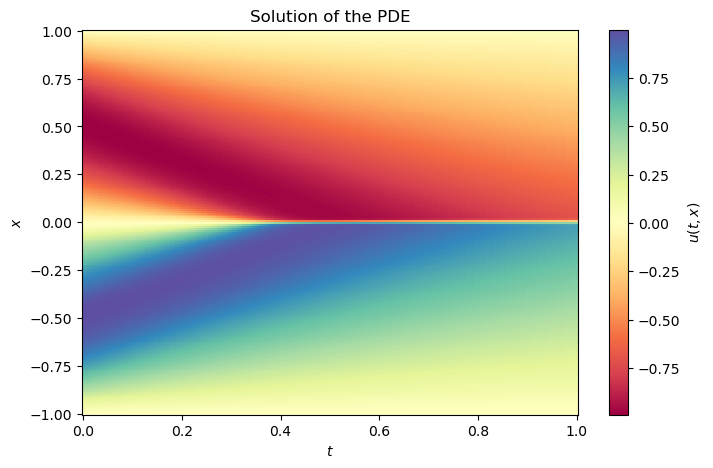

In [13]:
N = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N)
xspace = np.linspace(xmin, xmax, N)
T, X = np.meshgrid(tspace, xspace)

results = fwd(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N,N)

plot_results(T, X, results)

## Code rewritten using Flax

We will now attempt to rewrite the above network without relying explicitly on JAX (as if we were writing a MLP on pure numpy), but rather by employing [Flax](https://flax.readthedocs.io/en/latest/), a NN ecosystem for JAX, and mainly its `linen` package.

In [14]:
from typing import Sequence

import flax.linen as nn

Some of the most basic `linen` components, which are shown in the code below, are the following (see more [here](https://flax.readthedocs.io/en/latest/api_reference/flax.linen.html)):

- **Module**: base class for all modules - any NN defined as a class should subclass this class. `__call__` is the most popular forward pass choice. The `apply(variables,*args)` method applies a module method to variables and returns output and modified variables. The `init` method initializes a module method with variables and returns modified variables.

- **Dense**: a linear transformation applied over the last dimension of the input. Main arguments are `features` of type int (layer size) and `use_bias` of type bool.

Let us first define the MLP model.

In [15]:
class MLP(nn.Module):
    features: Sequence[int]

    # Setup the components of the network
    # This is an MLP, so the components are Dense layers
    def setup(self):
        # features is a list of integers, containing the sizes of each layer
        self.layers = [nn.Dense(features=feat, use_bias=True) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if idx != len(self.layers)-1:
                x = jnp.tanh(x) # don't apply tanh on final layer
        return x

Now, we define a function that calls the model, similarly to what was done through the `fwd` function of the previous case.

In [16]:
@jax.jit
def uNN(params, t, x):
    u = model.apply(params, jnp.concatenate((t,x),axis=1))
    return u

The `loss_fun` function is the same as before, but we rewrite it here because `ufunc` is defined through `uNN` instead of `fwd`.

In [17]:
def loss_fun(params,colloc,conds):
    # Split the collocation points data into their coordinates t and x
    t_c, x_c = colloc[:,[0]], colloc[:,[1]]
    # ufunc is the same as before, but instead of fwd we simply call
    # the aforementioned uNN function
    ufunc = lambda t,x : uNN(params,t,x)
    # Eq (1):
    mse_f = jnp.mean(PINN_f(t_c,x_c,ufunc)**2)

    mse_u = 0.0
    for cond in conds:
        t_b, x_b, u_b = cond[:,[0]], cond[:,[1]], cond[:,[2]]
        # Eq (2):
        mse_u += MSE(u_b,ufunc(t_b,x_b))
    return mse_f + mse_u

All these suffice. Now, we simply initialize the model and the optimizer.

In [18]:
# Setup the model
model = MLP([8, 8, 8, 8, 8, 8, 1])

# generate random keys at specific seed for debugging
key1, key2 = jax.random.split(jax.random.PRNGKey(420),num=2)

# Dummy input to initialize the model
dummy_in = jax.random.normal(key1, (2,))
# Initialization call
# The parameters could also be initialized as previously, but flax provides ready solutions
params = model.init(key2, dummy_in)

# Set scheduler for learning rate
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
# another option is adamw with weight decay as well, but here we try to replicate the previous case
optimizer = optax.adam(lr)
# initialize optimizer
opt_state = optimizer.init(params)

The training process is pretty much the same.

In [19]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,colloc,conds)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch={epoch}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=5.442e-01
Epoch=1000	loss=7.270e-02
Epoch=2000	loss=1.142e-02
Epoch=3000	loss=5.265e-03
Epoch=4000	loss=2.777e-03
Epoch=5000	loss=1.822e-03
Epoch=6000	loss=1.374e-03
Epoch=7000	loss=1.198e-03
Epoch=8000	loss=7.806e-03
Epoch=9000	loss=1.054e-03
Epoch=10000	loss=8.584e-04
Epoch=11000	loss=5.871e-04
Epoch=12000	loss=5.713e-04
Epoch=13000	loss=5.588e-04
Epoch=14000	loss=5.451e-04
Epoch=15000	loss=5.271e-04
Epoch=16000	loss=5.026e-04
Epoch=17000	loss=4.699e-04
Epoch=18000	loss=4.286e-04
Epoch=19000	loss=3.804e-04
CPU times: user 29.4 s, sys: 10.4 s, total: 39.8 s
Wall time: 35.5 s


Finally, visualize the results to compare with the previous implementation.

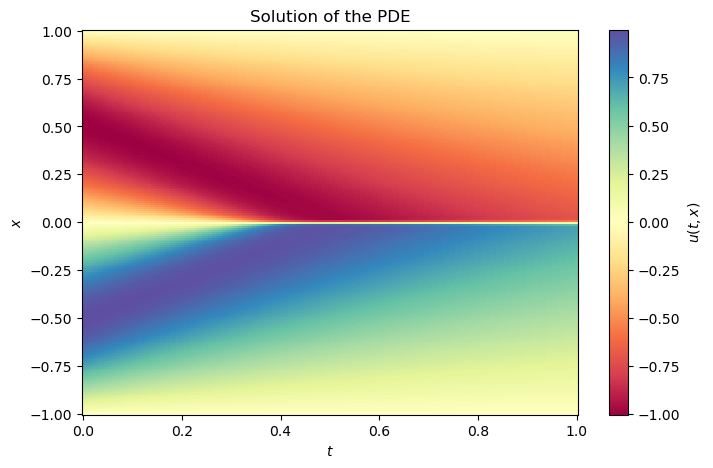

In [21]:
N = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N)
xspace = np.linspace(xmin, xmax, N)
T, X = np.meshgrid(tspace, xspace)

results = uNN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N,N)

plot_results(T, X, results)